In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import meijering, sato, frangi, hessian
from skimage.measure import label, regionprops
from sklearn import decomposition
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import rescale_intensity
from scipy import ndimage
import helpers

In [2]:
filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'
im = Image.open(filename)
imarr = np.array(im)

imarr_maskradius = helpers.remove_data_based_on_radius(imarr, mask_value=np.nan)

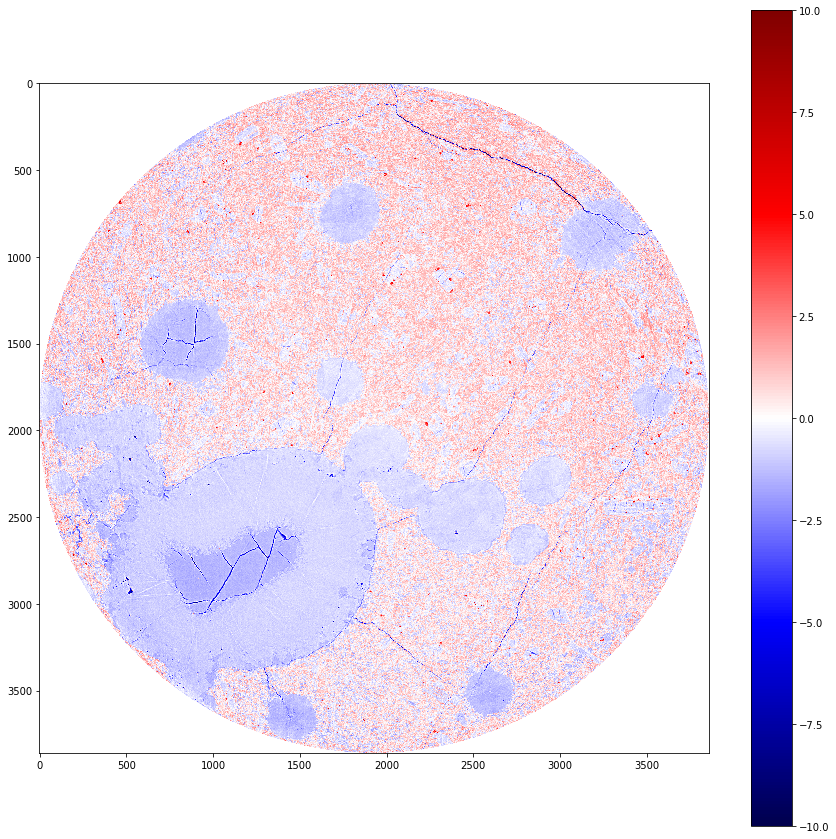

In [3]:
zim = helpers.zscore(imarr_maskradius)

fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(zim, cmap='seismic', vmin=-10, vmax=10)
fig.colorbar(cbar)

In [15]:
zim_remove = zim.copy()
zim_remove[zim_remove > -1.75] = 0

x1, y1 = zim_remove.nonzero()

zeros = np.zeros_like(zim_remove)

zeros[x1, y1] = 1

/home/john/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [24]:
zeros.min()

0.0

'\nThis more or less removes all data except for some noise and \nthe fractures. Using a smoothing algorithm to get rid of the rest\nof the noise should leave only the porosity.\n'

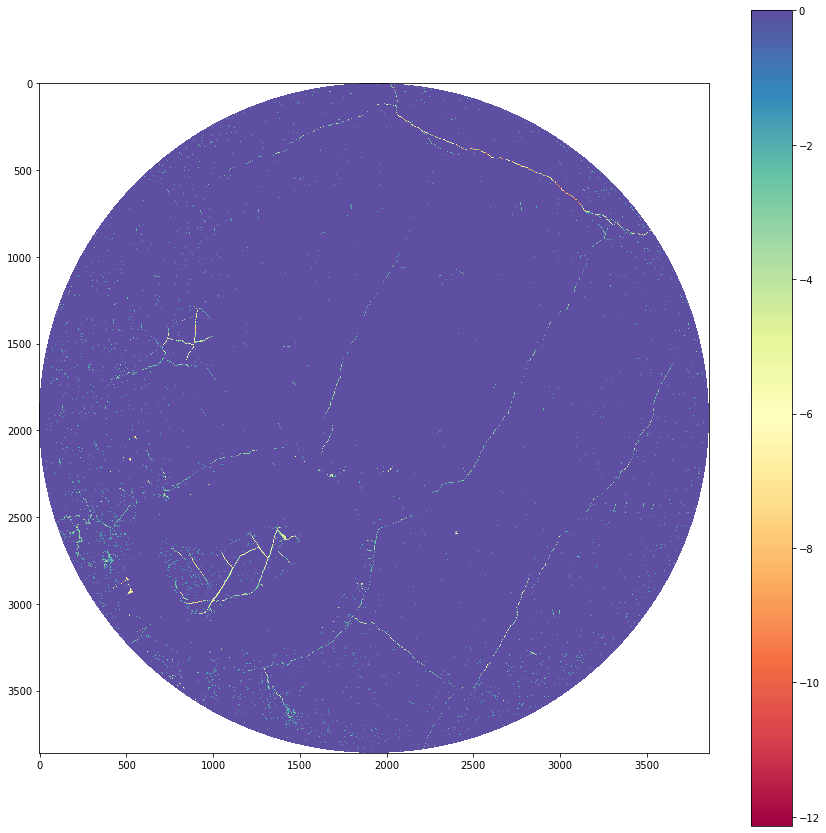

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(zim_remove, cmap='Spectral')
fig.colorbar(cbar)

"""
This more or less removes all data except for some noise and 
the fractures. Using a smoothing algorithm to get rid of the rest
of the noise should leave only the porosity.
"""

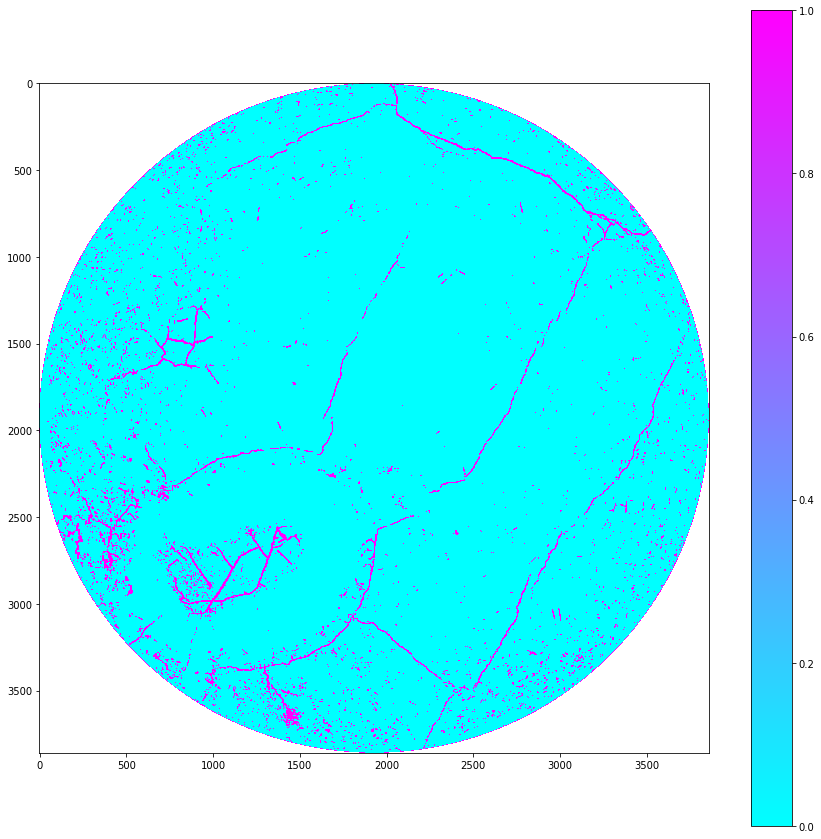

In [43]:
# footprint condition says value should be greater
# in all directions
footprint1 = np.array(
    [[1, 1, 1]
    ,[1, 0, 1]
    ,[1, 1, 1]]
)

footprint2 = np.array(
    [[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 0, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]]
)

# creates a window based on the given footprint
# to compare neighbors and replace values on 
# nearest maximum value
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html
newim = ndimage.median_filter(zeros, footprint=footprint1, mode='constant')
newim = ndimage.maximum_filter(newim, footprint=footprint2, mode='constant')
# newim = ndimage.maximum_filter(zim_remove, footprint=footprint2, mode='constant')

fig, ax = plt.subplots(figsize=(15, 15))

imlabeled = helpers.remove_data_based_on_radius(newim, mask_value=np.nan)

cbar = ax.imshow(imlabeled, cmap='cool')

fig.colorbar(cbar)


In [82]:
zeros_p = helpers.remove_data_based_on_radius(zeros, mask_value=np.nan)

In [83]:
print('first estimate of porosity? :', zeros_p[zeros_p==1].sum()/(zeros_p.shape[0]*zeros_p.shape[1]))

first estimate of porosity? : 0.010263646345280358


In [72]:
from skimage.measure import label, regionprops

In [80]:
labs = label(newim)
props = regionprops(labs, extra_properties=['bbox_area', 'centroid', 'convex_area', 'eccentricity', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length'])

TypeError: regionprops() got an unexpected keyword argument 'extra_properties'

In [66]:
len(props)

4153

In [70]:
props[0]

In [77]:
PROPS = {
    'Area': 'area',
    'BoundingBox': 'bbox',
    'BoundingBoxArea': 'bbox_area',
    'CentralMoments': 'moments_central',
    'Centroid': 'centroid',
    'ConvexArea': 'convex_area',
    # 'ConvexHull',
    'ConvexImage': 'convex_image',
    'Coordinates': 'coords',
    'Eccentricity': 'eccentricity',
    'EquivDiameter': 'equivalent_diameter',
    'EulerNumber': 'euler_number',
    'Extent': 'extent',
    # 'Extrema',
    'FeretDiameterMax': 'feret_diameter_max',
    'FilledArea': 'filled_area',
    'FilledImage': 'filled_image',
    'HuMoments': 'moments_hu',
    'Image': 'image',
    'InertiaTensor': 'inertia_tensor',
    'InertiaTensorEigvals': 'inertia_tensor_eigvals',
    'IntensityImage': 'intensity_image',
    'Label': 'label',
    'LocalCentroid': 'local_centroid',
    'MajorAxisLength': 'major_axis_length',
    'MaxIntensity': 'max_intensity',
    'MeanIntensity': 'mean_intensity',
    'MinIntensity': 'min_intensity',
    'MinorAxisLength': 'minor_axis_length',
    'Moments': 'moments',
    'NormalizedMoments': 'moments_normalized',
    'Orientation': 'orientation',
    'Perimeter': 'perimeter',
    'CroftonPerimeter': 'perimeter_crofton',
    # 'PixelIdxList',
    # 'PixelList',
    'Slice': 'slice',
    'Solidity': 'solidity',
    # 'SubarrayIdx'
    'WeightedCentralMoments': 'weighted_moments_central',
    'WeightedCentroid': 'weighted_centroid',
    'WeightedHuMoments': 'weighted_moments_hu',
    'WeightedLocalCentroid': 'weighted_local_centroid',
    'WeightedMoments': 'weighted_moments',
    'WeightedNormalizedMoments': 'weighted_moments_normalized'
}

OBJECT_COLUMNS = {
    'image', 'coords', 'convex_image', 'slice',
    'filled_image', 'intensity_image'
}

COL_DTYPES = {
    'area': int,
    'bbox': int,
    'bbox_area': int,
    'moments_central': float,
    'centroid': float,
    'convex_area': int,
    'convex_image': object,
    'coords': object,
    'eccentricity': float,
    'equivalent_diameter': float,
    'euler_number': int,
    'extent': float,
    'feret_diameter_max': float,
    'filled_area': int,
    'filled_image': object,
    'moments_hu': float,
    'image': object,
    'inertia_tensor': float,
    'inertia_tensor_eigvals': float,
    'intensity_image': object,
    'label': int,
    'local_centroid': float,
    'major_axis_length': float,
    'max_intensity': float,
    'mean_intensity': float,
    'min_intensity': float,
    'minor_axis_length': float,
    'moments': float,
    'moments_normalized': float,
    'orientation': float,
    'perimeter': float,
    'perimeter_crofton': float,
    'slice': object,
    'solidity': float,
    'weighted_moments_central': float,
    'weighted_centroid': float,
    'weighted_moments_hu': float,
    'weighted_local_centroid': float,
    'weighted_moments': float,
    'weighted_moments_normalized': float
}

PROP_VALS = set(PROPS.values())

def _props_to_dict(regions, properties=('label', 'bbox'), separator='-'):
    """Convert image region properties list into a column dictionary.
    Parameters
    ----------
    regions : (N,) list
        List of RegionProperties objects as returned by :func:`regionprops`.
    properties : tuple or list of str, optional
        Properties that will be included in the resulting dictionary
        For a list of available properties, please see :func:`regionprops`.
        Users should remember to add "label" to keep track of region
        identities.
    separator : str, optional
        For non-scalar properties not listed in OBJECT_COLUMNS, each element
        will appear in its own column, with the index of that element separated
        from the property name by this separator. For example, the inertia
        tensor of a 2D region will appear in four columns:
        ``inertia_tensor-0-0``, ``inertia_tensor-0-1``, ``inertia_tensor-1-0``,
        and ``inertia_tensor-1-1`` (where the separator is ``-``).
        Object columns are those that cannot be split in this way because the
        number of columns would change depending on the object. For example,
        ``image`` and ``coords``.
    Returns
    -------
    out_dict : dict
        Dictionary mapping property names to an array of values of that
        property, one value per region. This dictionary can be used as input to
        pandas ``DataFrame`` to map property names to columns in the frame and
        regions to rows.
    Notes
    -----
    Each column contains either a scalar property, an object property, or an
    element in a multidimensional array.
    Properties with scalar values for each region, such as "eccentricity", will
    appear as a float or int array with that property name as key.
    Multidimensional properties *of fixed size* for a given image dimension,
    such as "centroid" (every centroid will have three elements in a 3D image,
    no matter the region size), will be split into that many columns, with the
    name {property_name}{separator}{element_num} (for 1D properties),
    {property_name}{separator}{elem_num0}{separator}{elem_num1} (for 2D
    properties), and so on.
    For multidimensional properties that don't have a fixed size, such as
    "image" (the image of a region varies in size depending on the region
    size), an object array will be used, with the corresponding property name
    as the key.
    Examples
    --------
    >>> from skimage import data, util, measure
    >>> image = data.coins()
    >>> label_image = measure.label(image > 110, connectivity=image.ndim)
    >>> proplist = regionprops(label_image, image)
    >>> props = _props_to_dict(proplist, properties=['label', 'inertia_tensor',
    ...                                              'inertia_tensor_eigvals'])
    >>> props  # doctest: +ELLIPSIS +SKIP
    {'label': array([ 1,  2, ...]), ...
     'inertia_tensor-0-0': array([  4.012...e+03,   8.51..., ...]), ...
     ...,
     'inertia_tensor_eigvals-1': array([  2.67...e+02,   2.83..., ...])}
    The resulting dictionary can be directly passed to pandas, if installed, to
    obtain a clean DataFrame:
    >>> import pandas as pd  # doctest: +SKIP
    >>> data = pd.DataFrame(props)  # doctest: +SKIP
    >>> data.head()  # doctest: +SKIP
       label  inertia_tensor-0-0  ...  inertia_tensor_eigvals-1
    0      1         4012.909888  ...                267.065503
    1      2            8.514739  ...                  2.834806
    2      3            0.666667  ...                  0.000000
    3      4            0.000000  ...                  0.000000
    4      5            0.222222  ...                  0.111111
    """

    out = {}
    n = len(regions)
    for prop in properties:
        r = regions[0]
        rp = getattr(r, prop)
        if prop in COL_DTYPES:
            dtype = COL_DTYPES[prop]
        else:
            func = r._extra_properties[prop]
            dtype = _infer_regionprop_dtype(
                func,
                intensity=r._intensity_image is not None,
                ndim=r.image.ndim,
            )
        column_buffer = np.zeros(n, dtype=dtype)

        # scalars and objects are dedicated one column per prop
        # array properties are raveled into multiple columns
        # for more info, refer to notes 1
        if np.isscalar(rp) or prop in OBJECT_COLUMNS or dtype is np.object_:
            for i in range(n):
                column_buffer[i] = regions[i][prop]
            out[prop] = np.copy(column_buffer)
        else:
            if isinstance(rp, np.ndarray):
                shape = rp.shape
            else:
                shape = (len(rp),)

            for ind in np.ndindex(shape):
                for k in range(n):
                    loc = ind if len(ind) > 1 else ind[0]
                    column_buffer[k] = regions[k][prop][loc]
                modified_prop = separator.join(map(str, (prop,) + ind))
                out[modified_prop] = np.copy(column_buffer)
    return out

In [79]:
pd.DataFrame(_props_to_dict(props))

,label,bbox-0,bbox-1,bbox-2,bbox-3
0,1,0,0,1870,1870
1,2,0,1989,1870,3859
2,3,1,1908,7,1914
3,4,16,1771,22,1777
4,5,18,2017,25,2024
5,6,20,1677,29,1688
6,7,21,1913,28,1923
7,8,23,2105,30,2110
8,9,25,1790,32,1798
9,10,28,2218,35,2224
